In [67]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_tavily import TavilySearch
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from uuid import uuid4
import json

load_dotenv()

model = ChatGroq(model="llama-3.3-70b-versatile")


In [62]:
search_tool = TavilySearchResults(max_results=4)

response_tool = search_tool.invoke("What is the weather in Mumbai today?")

tools = [search_tool]

memory = MemorySaver()

In [63]:
print(response_tool)

[{'title': 'Mumbai Weather Forecast 29 Jun 2025 - Times of India', 'url': 'https://timesofindia.indiatimes.com/weather/mumbai-weather-forecast-today/400070', 'content': "Today's Weather in Mumbai: In Mumbai today, the weather is expected to be Light Rain Shower with a maximum temperature of 31°C and a minimum of 26°C.", 'score': 0.9667167}, {'title': 'Mumbai Weather Today (Sunday, Jun 29, 2025) - India Today', 'url': 'https://www.indiatoday.in/weather/mumbai-weather-forecast-today', 'content': 'The minimum temperature in Mumbai today is likely to hover around 26 degrees Celsius, while the maximum temperature might reach 31 degrees Celsius. The mercury level is expected to hover around 29 degrees Celsius throughout the day, with the wind speed around 10.56. The wind will move around 224 degrees with a gust speed of 13.5. The sunrise time is 06:03 AM, while it will set at 07:19 PM on Sunday. As per the seven-day weather prediction, the temperature in Mumbai is likely to reach 31 degrees 

In [64]:
llm_with_tools = model.bind_tools(tools=tools)

In [66]:
response1 = llm_with_tools.invoke("What is the weather in Mumbai today?")

print(response1)

content='' additional_kwargs={'tool_calls': [{'id': '5e3saf1ys', 'function': {'arguments': '{"query":"Mumbai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.076363636, 'prompt_time': 0.021769824, 'queue_time': 0.055186346000000004, 'total_time': 0.09813346}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--17d52bad-e37e-45dc-9cde-a8cb067409a9-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Mumbai weather today'}, 'id': '5e3saf1ys', 'type': 'tool_call'}] usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307}


In [77]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)
graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)

# Correct: Set entry point to "model" directly
graph_builder.set_entry_point("model")

# Conditional edges after model
graph_builder.add_conditional_edges("model", tools_router, {
    "tool_node": "tool_node",
    "__end__": END
})

graph_builder.add_edge("tool_node", "model")  # Loop back after tools
graph_builder.add_edge("model", "__end__")    # End if no tools needed

graph = graph_builder.compile(checkpointer=memory)



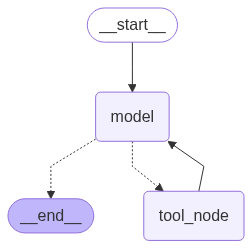

In [78]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Generate PNG from graph
png_data = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

# Optionally save image locally
with open("langgraph_diagram.png", "wb") as f:
    f.write(png_data)

# Display the image
display(Image(png_data))


In [79]:
config = {
    "configurable": {
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='52a02c73-9495-4a04-9c53-c6f4435b3ea7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'p5tt13xtd', 'function': {'arguments': '{"query":"next SpaceX launch"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 286, 'total_tokens': 306, 'completion_time': 0.079470336, 'prompt_time': 0.021621525, 'queue_time': 0.051403669, 'total_time': 0.101091861}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5f2b02ff-a00b-4bbb-b299-a55f013253d2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch'}, 'id': 'p5tt13xtd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 20, 'total_tokens': 306}),
  ToolMessage(content='[{"tit

In [80]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '207cbeef-b97f-4902-88b0-bb3eb0f0c33e', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='71c188db-9a13-46e4-8234-6d488abba4c8')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '696bb85c-8ae2-4804-8016-29e8b13a2b0d', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:d2bce08d-d4f5-c7b1-997f-f8bcf40c9311'}, 'parent_ids': ['207cbeef-b97f-4902-88b0-bb3eb0f0c33e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='When is the next spa